In [65]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, EfficientSU2, UniformDistribution, NormalDistribution

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import NumPyDiscriminator, QGAN

seed = 71
np.random.seed = seed
algorithm_globals.random_seed = seed

In [77]:
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, SLSQP

n = 2
mean = [2**(n-1), 2**(n-1)]
cov = [[1, 0.2], [0.2, 1]]
number_of_training_sample = 1000

real_data = np.random.multivariate_normal(mean, cov, number_of_training_sample)
num_qubits = [n, n]
bounds = [[0, 2**n-1], [0, 2**n-1]]
num_epochs = 400
batch_size = 200
entanglement_map = [[0,1], [2,3]]

discretised_real_data = np.round(real_data)
qgan = QGAN(discretised_real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend("statevector_simulator"), seed_transpiler=seed, seed_simulator=seed)

# Set an initial state for the generator circuit as a uniform distribution
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cx", entanglement='linear', reps=2)
# ansatz = TwoLocal(int(np.sum(num_qubits)), "ry", "cz", entanglement='linear', reps=3)
# ansatz = EfficientSU2(int(np.sum(num_qubits)), entanglement='linear', reps=2)


# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

# Set quantum generator
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

/var/folders/d1/7ljpg1_d429bsgwdcxv9yr340000gn/T/ipykernel_24858/2293517137.py:22: DeprecationWarning: `UniformDistribution` is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. It moved to qiskit_finance.circuit.library.UniformDistribution.
  init_dist = UniformDistribution(sum(num_qubits))


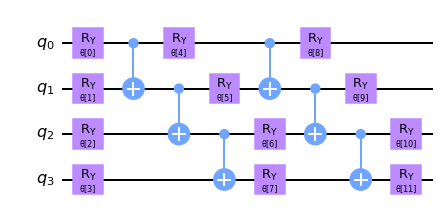

In [78]:
ansatz.decompose().draw('mpl')

In [79]:
# Run qGAN for "number_of_trial" runs and find the best trial with the minimum relative entropy
result_set = {}
number_of_trial = 5
for trial in range(number_of_trial):
    init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi
    qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
    result = qgan.run(quantum_instance)
    result_set[trial] = [result['params_g'], result['rel_entr']]
    print(trial, result['rel_entr'])
    trial += 1
    
minimum_relative_entropy_trial = 0
for trial in range(number_of_trial):
    if(result_set[trial][1] < result_set[minimum_relative_entropy_trial][1]): 
        minimum_relative_entropy_trial = trial    

qgan.set_generator(generator_circuit=g_circuit, generator_init_params=result_set[minimum_relative_entropy_trial][0])
result = qgan.run(quantum_instance)

0 0.7908
1 1.1452
2 1.5681
3 1.1034
4 1.5364


In [80]:
print("Training results:")
for key, value in result.items():
    print(f"  {key} : {value}")

Training results:
  params_d : [0.06415066 0.43694785 0.44637629 ... 0.80447005 0.53104842 1.59399451]
  params_g : [5.98818156 3.19384927 2.26946555 3.3036783  2.60570076 0.80800568
 5.03075902 1.28523163 3.95482687 1.13634629 5.40397081 0.31190115]
  loss_d : 0.5307
  loss_g : [0.7029]
  rel_entr : 0.8307


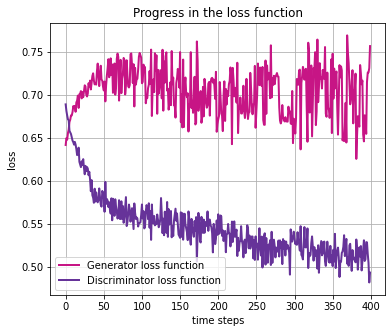

In [81]:
# Plot progress w.r.t the generator's and the discriminator's loss function
initial = num_epochs*minimum_relative_entropy_trial
final = num_epochs*(minimum_relative_entropy_trial+1)
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6, 5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss[initial:final], label="Generator loss function", color="mediumvioletred", linewidth=2)
plt.plot(t_steps, qgan.d_loss[initial:final], label="Discriminator loss function", color="rebeccapurple", linewidth=2)
plt.grid()
plt.legend(loc="best")
plt.xlabel("time steps")
plt.ylabel("loss")
plt.show()

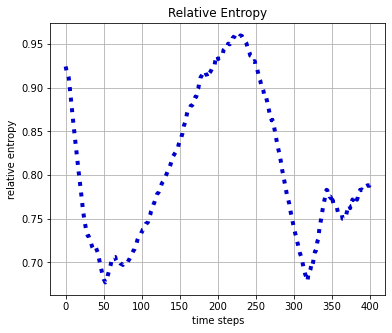

In [87]:
# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr[initial:final])), qgan.rel_entr[initial:final], color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

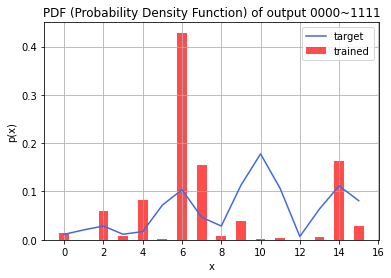

In [104]:
temp = []
for i in range(int(bounds[0][1] + 1)):
    for j in range(int(bounds[1][1] + 1)):
        freq = 0
        for k in range(len(discretised_real_data)):
            if(discretised_real_data[k][0]==i and discretised_real_data[k][1]==j):
                freq += 1
        temp.append(freq)        
discretised_real_data_dist = np.array(temp) / sum(temp)
discretised_real_data_dist = discretised_real_data_dist.reshape(2**n,2**n)
plt.title("PDF (Probability Density Function) of output 0000~1111")
# plt.hist(sampling.T[1], density=True, alpha=0.7, color='royalblue', width=0.5, label='trained', bins=np.arange(-1/2**n, 2**n+1, 1))
# plt.hist(discretised_real_data.T[1], density=True, color="deepskyblue", alpha=0.7, width=0.5, label='target', bins=np.arange(0, 2**n+1, 1))
plt.plot(discretised_real_data_dist.reshape(-1), color="royalblue", label="target")
plt.bar(range(2**(2*n)), prob_g.reshape(-1), alpha=0.7,  width=0.5, color="red", label="trained")
plt.grid()
plt.xlabel("x")
plt.ylabel("p(x)")
plt.legend(loc="best")


In [103]:
# # # Plot the CDF of the resulting distribution against the target distribution, i.e. log-gaussian
# # gaussian = np.random.multivariate_normal(mean, cov, number_of_training_sample).T
# # gaussian_x = np.round(gaussian[0])
# # gaussian_x = gaussian_x[gaussian_x >= bounds[0][0]]
# # gaussian_x = gaussian_x[gaussian_x <= bounds[0][1]]
# # gaussian_y = np.round(gaussian[1])
# # gaussian_y = gaussian_y[gaussian_y >= bounds[1][0]]
# # gaussian_y = gaussian_y[gaussian_y <= bounds[1][1]]
# # gaussian_discretized = [gaussian_x, gaussian_y]
# # temp_x = []
# # temp_y = []
# # for i in range(int(bounds[0][1] + 1)):
# #     temp_x += [np.sum(gaussian_x == i)]
# #     temp_y += [np.sum(gaussian_y == i)]
# # gaussian_x = np.array(temp_x / sum(temp_x))
# # gaussian_y = np.array(temp_y / sum(temp_y))

# samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10**4)

# prob_g = np.array(prob_g).reshape(2**n,2**n).T
# m=2**num_qubits[0]
# inds=np.random.choice(np.arange(m**2), p=prob_g.reshape(-1), size=10**(7), replace=True)
# sampling = np.array([inds//m, inds%m]).T

# samples_g_1d = np.unique(np.array(samples_g).T)

# prob_1d_x = np.array(prob_g).sum(axis = 1)
# prob_1d_y = np.array(prob_g).sum(axis = 0)


# plt.figure(figsize=(16, 5))
# plt.subplot(1, 2, 1)
# plt.title("PDF (Probability Density Function) of x coordinate")
# plt.hist(sampling.T[0], density=True, alpha=0.7, color='royalblue', width=0.5, label='trained', bins=np.arange(-1/2**n, 2**n+1, 1))
# plt.hist(discretised_real_data.T[0], density=True, color="deepskyblue", alpha=0.7, width=0.5, label='target', bins=np.arange(0, 2**n+1, 1))
# # plt.plot(gaussian_x, "-o", label="target", color="deepskyblue", linewidth=4, markersize=12)
# # plt.plot(real_data_x_PDF, '-o', label='target', color='deepskyblue', linewidth=4, markersize=12)
# # plt.bar(samples_g_1d,  prob_1d_x, color='royalblue', width=0.8, label='trained')
# plt.grid()
# plt.xlabel("x")
# plt.ylabel("p(x)")
# plt.legend(loc="best")

# plt.subplot(1, 2, 2)
# plt.title("PDF (Probability Density Function) of y coordinate")
# plt.hist(sampling.T[1], density=True, alpha=0.7, color='royalblue', width=0.5, label='trained', bins=np.arange(-1/2**n, 2**n+1, 1))
# plt.hist(discretised_real_data.T[1], density=True, color="deepskyblue", alpha=0.7, width=0.5, label='target', bins=np.arange(0, 2**n+1, 1))
# # plt.plot(gaussian_y, "-o", label="target", color="deepskyblue", linewidth=4, markersize=12)
# plt.grid()
# plt.xlabel("y")
# plt.ylabel("p(y)")
# plt.legend(loc="best")
# plt.show()

In [85]:
# import seaborn as sns
# import numpy as np
# import pandas as pd
# from scipy.stats import norm



# axs = sns.jointplot(gaussian[0], gaussian[1])
# axs.ax_joint.scatter(gaussian[0], gaussian[1], c='r')

# axs.ax_marg_x.cla()
# axs.ax_marg_y.cla()
# sns.distplot(sampling.T[0], ax=axs.ax_marg_x)
# sns.distplot(gaussian_discretized[0], ax=axs.ax_marg_x)
# sns.distplot(sampling.T[1], ax=axs.ax_marg_y, vertical=True)
# sns.distplot(gaussian_discretized[1], ax=axs.ax_marg_y, vertical=True)
